# 2022-01-08 • 1000-to-1

In [9]:
include("nb_init.jl");

using Revise
using Distributions
using DataFrames
using PartialFunctions: $
using PyFormattedStrings, LaTeXStrings, FilePaths
using Unitful: mV, Hz, ms, s as second, minute
using PyPlot: PyPlot as plt, matplotlib as mpl
using VoltageToMap


In [10]:
save = savefig $ (; subdir="methods");

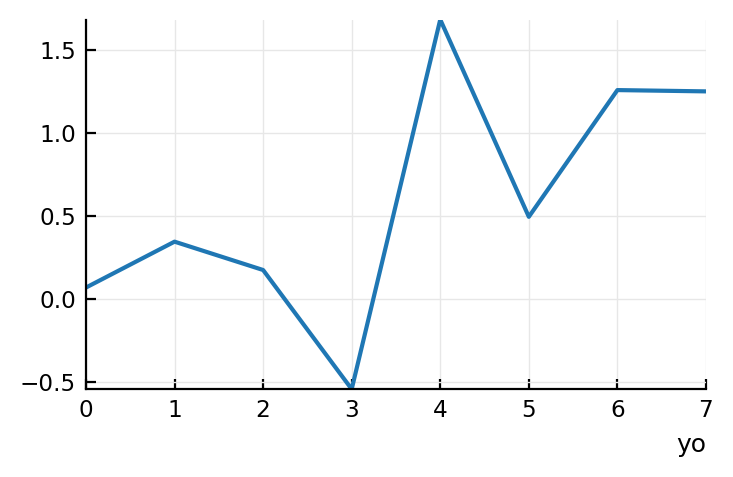

In [25]:
fig,ax=plt.subplots()
ax.plot(randn(8))
# ax.set(xlabel=("yo", :loc=>"right"))
ax.set_xlabel("yo", loc="right");

## Firing rates

We want Poisson firing, i.e. ISIs with an exponential distribution.  
Firing rates lognormally distributed (instead of all the same, as before).

In [26]:
"""
`μ` and `σ` are mean and standard deviation of the underlying Gaussian.
`μₓ` is the mean of the log of the Gaussian.
"""
function LogNormal_with_mean(μₓ, σ)
    μ = log(μₓ) - σ^2 / 2
    LogNormal(μ, σ)
end;

In [27]:
# Mean and variance from Roxin2011 (cross checked with its refs Hromádka, O'Connor).
input_spike_rate = LogNormal_with_mean(4, √0.6)  # (Hz, dimensionless)

LogNormal{Float64}(μ=1.0862943611198905, σ=0.7745966692414834)

In [28]:
roxin = LogNormal_with_mean(5, √1.04)

LogNormal{Float64}(μ=1.0894379124341003, σ=1.019803902718557)

In [29]:
gauss_variance = σ² = (σ_X, μ_X) -> log(1 + σ_X^2 / μ_X^2)
gauss_variance(7.4, 12.6)  # for oconnor

0.296337

In [30]:
oconnor = LogNormal_with_mean(7.4, √0.3)

LogNormal{Float64}(μ=1.8514800002101244, σ=0.5477225575051661)

In [31]:
# Define probability distributions on unitful quantities.
Distributions.pdf(d, x::Quantity) = pdf(d, ustrip(x)) / unit(x)
Distributions.cdf(d, x::Quantity) = cdf(d, ustrip(x))

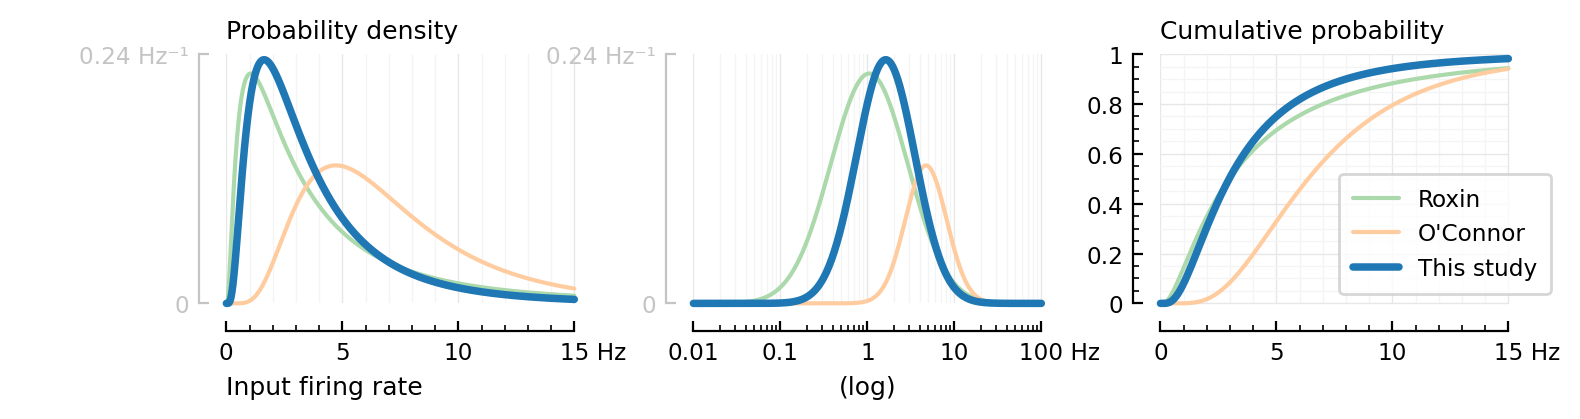

In [176]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8, 2.2))

rlin = (0:0.01:15)Hz
rlog = exp10.(-2:0.01:2)Hz
function plot_firing_rate_distr(distr; kw...)
    plot(rlin, pdf.(distr, rlin), ax1; clip_on=false, kw...)
    plot(rlog, pdf.(distr, rlog), ax2; clip_on=false, xscale="log", kw...)
    plot(rlin, cdf.(distr, rlin), ax3; clip_on=false, ylim=(0,1), kw...)
end

plot_firing_rate_distr(roxin, label="Roxin", c=lighten(C2, 0.6))
plot_firing_rate_distr(oconnor, label="O'Connor", c=lighten(C1, 0.6))
plot_firing_rate_distr(input_spike_rate, label="This study", c=C0, lw=2.7)

set(ax1; ytickstyle=:range, xlabel="Input firing rate")
set(ax2; ytickstyle=:range)
legend(ax3; loc="lower left", bbox_to_anchor=(0.5, 0.02))
ylabel(ax1, "Probability density")
ylabel(ax3, "Cumulative probability")
ax2.set_xlabel("(log)", loc="center")
deemph.(:yaxis, [ax1, ax2])
plt.tight_layout(w_pad=-5)

save("log-normal.pdf")

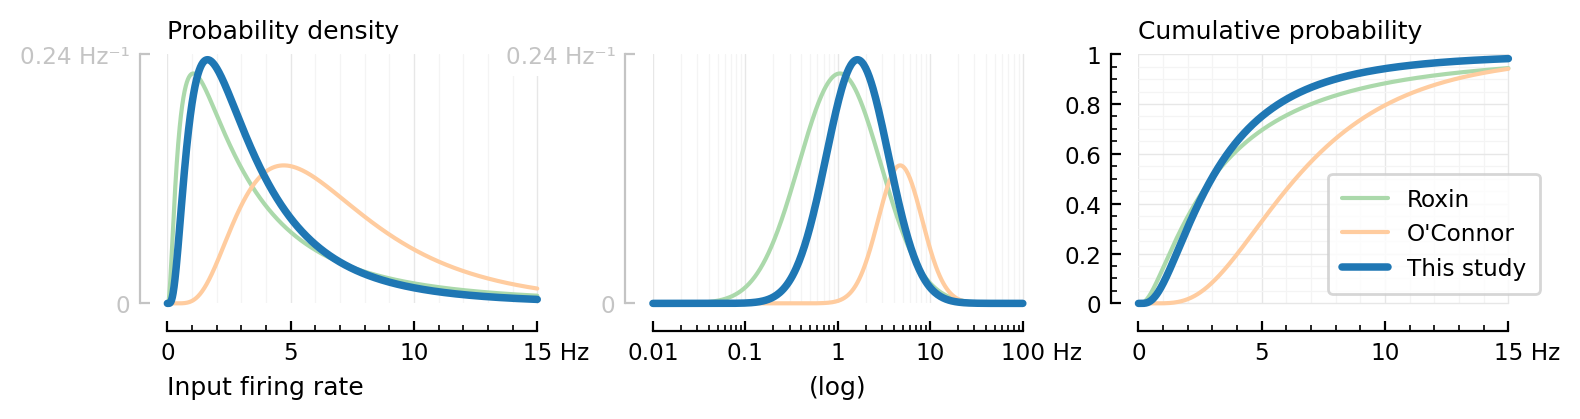

In [219]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8, 2.2))

rlin = (0:0.01:15)Hz
rlog = exp10.(-2:0.01:2)Hz
function plot_firing_rate_distr(distr; kw...)
    plot(rlin, pdf.(distr, rlin), ax1; clip_on=false, kw...)
    plot(rlog, pdf.(distr, rlog), ax2; clip_on=false, xscale="log", kw...)
    plot(rlin, cdf.(distr, rlin), ax3; clip_on=false, ylim=(0,1), kw...)
end

plot_firing_rate_distr(roxin, label="Roxin", c=lighten(C2, 0.6))
plot_firing_rate_distr(oconnor, label="O'Connor", c=lighten(C1, 0.6))
plot_firing_rate_distr(input_spike_rate, label="This study", c=C0, lw=2.7)

set(ax1; ytickstyle=:range, xlabel="Input firing rate")
set(ax2; ytickstyle=:range)
legend(ax3; loc="lower left", bbox_to_anchor=(0.5, 0.02))
ylabel(ax1, "Probability density")
ylabel(ax3, "Cumulative probability")
ax2.set_xlabel("(log)", loc="center")
deemph.(:yaxis, [ax1, ax2])
plt.tight_layout(w_pad=-3)

save("log-normal.pdf")

In [9]:
distrs = [oconnor, roxin, input_spike_rate]
DataFrame(
    σ=getfield.(distrs, :σ),
    mean=mean.(distrs),
    median=median.(distrs),
    std=std.(distrs),
    var=var.(distrs),
)

,σ,mean,median,std,var
,Float64,Float64,Float64,Float64,Float64
1,0.547723,7.4,6.36924,4.37702,19.1583
2,1.0198,5.0,2.9726,6.76243,45.7304
3,0.774597,4.0,2.96327,3.62683,13.1539


## .

In [42]:
Nunconn = 100
Nexc    = 5200
Ninh    = Nexc ÷ 4

1300

In [43]:
Ninh + Nexc

6500

In [44]:
using DataStructures: PriorityQueue
using Unitful: Time

In [55]:
λ = rand(input_spike_rate, Nexc)  # Hz
exps = Exponential.(λ)  # Hz
first_spiketimes = rand.(exps) * second

pq = PriorityQueue{Int, Time}()
for (i, t) in enumerate(first_spiketimes)
    enqueue!(pq, i => t)
end

sim_duration = 10*second;
selected_spiker = argmin(first_spiketimes)
t = 0.0*second
ts = Vector{typeof(t)}()
while t < sim_duration
    i, t = dequeue_pair!(pq)  # earliest spike
    new_ISI = rand(exps[i]) * second
    enqueue!(pq, i => t + new_ISI)
    if i == selected_spiker
        push!(ts, t)
    end
end

LoadError: MethodError: no method matching Exponential(::Float64)
[0mClosest candidates are:
[0m  Exponential([91m::Quantity[39m) at C:\Users\tfiers\OneDrive\PhD\voltage-to-wiring-sim\src\unitfuldistributions.jl:22

In [535]:
using OrdinaryDiffEq
using ComponentArrays
using Parameters
using Unitful: nS, pF, pA

In [523]:
@with_kw struct IzhikevichParams
    C = 100 * pF
    k = 0.7 * (nS/mV)
    b = -2 * nS
    v_r    = -60 * mV
    v_t    = -40 * mV
    v_peak =  35 * mV
    c      = -50 * mV
    a = 0.03 / ms
    d = 100 * pA
end
cortical_RS = IzhikevichParams();

τ_syn = 7 * ms;

In [590]:
function f(D, vars, params, t)
    @unpack C, k, b, v_r, v_t, v_peak, c, a, d = params
    @unpack v, u = vars
    D.v = (k * (v - v_r) * (v - v_t) - u) / C
    D.u = a * (b * (v - v_r) - u)
    D.g = -g / τ_syn
    return nothing
end

x0 = ComponentArray(v = -80.0mV, u = 0.0pA)
prob = ODEProblem(f, x0, float(sim_duration), cortical_RS)
Δt = 0.1ms
integrator = init(prob, Tsit5(); Δt, adaptive=true)

t: 0.0 s
u: ComponentVector{Quantity{Float64}}(v = -80.0 mV, u = 0.0 pA)

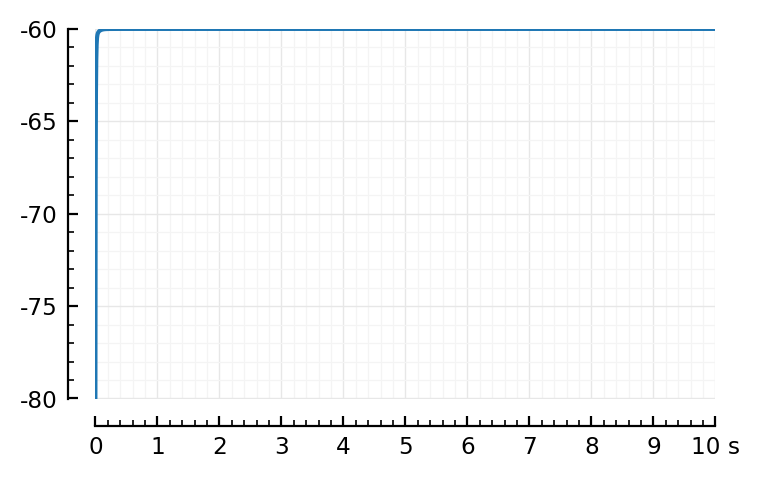

In [617]:
t = 0ms:0.1ms:sim_duration
v = t -> sol(t).v / mV |> NoUnits
plot(t, v.(t));